RESERVOIR NEURAL NETWORK (ECHO STATE NETWORK)
Ứng dụng: Dự đoán chuỗi thời gian Mackey-Glass

Đang tạo chuỗi thời gian Mackey-Glass...
Độ dài chuỗi: 5000
Giá trị min: 0.0000, max: 1.3413

Đã khởi tạo lớp Echo State Network!

CHUẨN BỊ DỮ LIỆU
Kích thước dữ liệu huấn luyện: (3000, 1)
Kích thước dữ liệu test: (1000, 1)

HUẤN LUYỆN ESN CHO DỰ ĐOÁN GẦN: x(t+10)
Đang huấn luyện...
Đang dự đoán trên tập test...

Kết quả dự đoán x(t+10):
  - MSE:   0.008481
  - RMSE:  0.092090
  - NRMSE: 0.064138

HUẤN LUYỆN ESN CHO DỰ ĐOÁN XA: x(t+100)
Đang huấn luyện...
Đang dự đoán trên tập test...

Kết quả dự đoán x(t+100):
  - MSE:   0.070696
  - RMSE:  0.265887
  - NRMSE: 0.185183


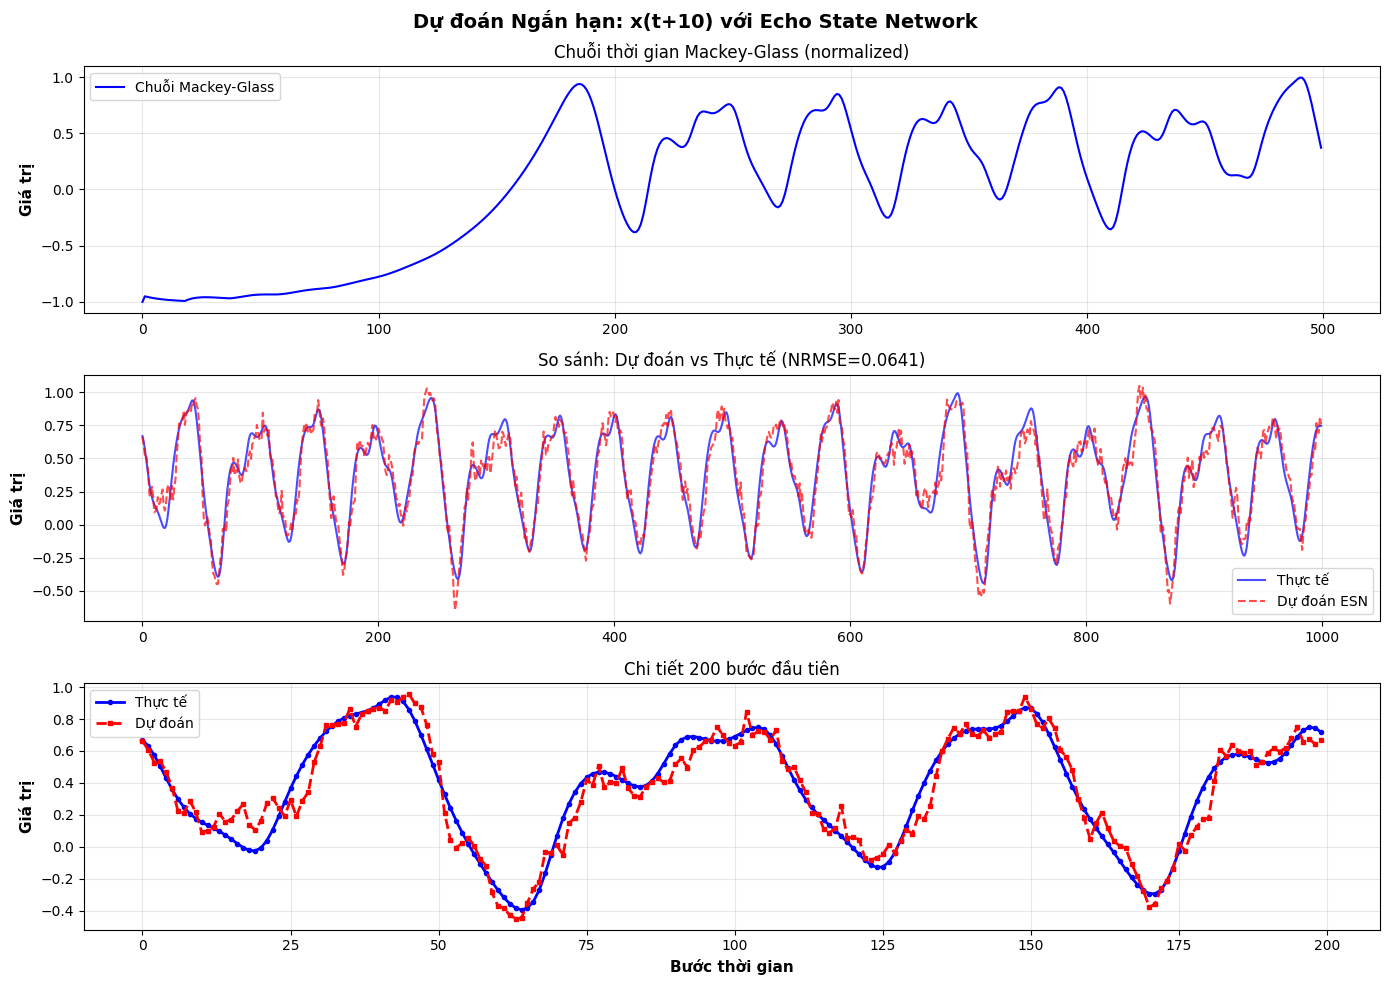

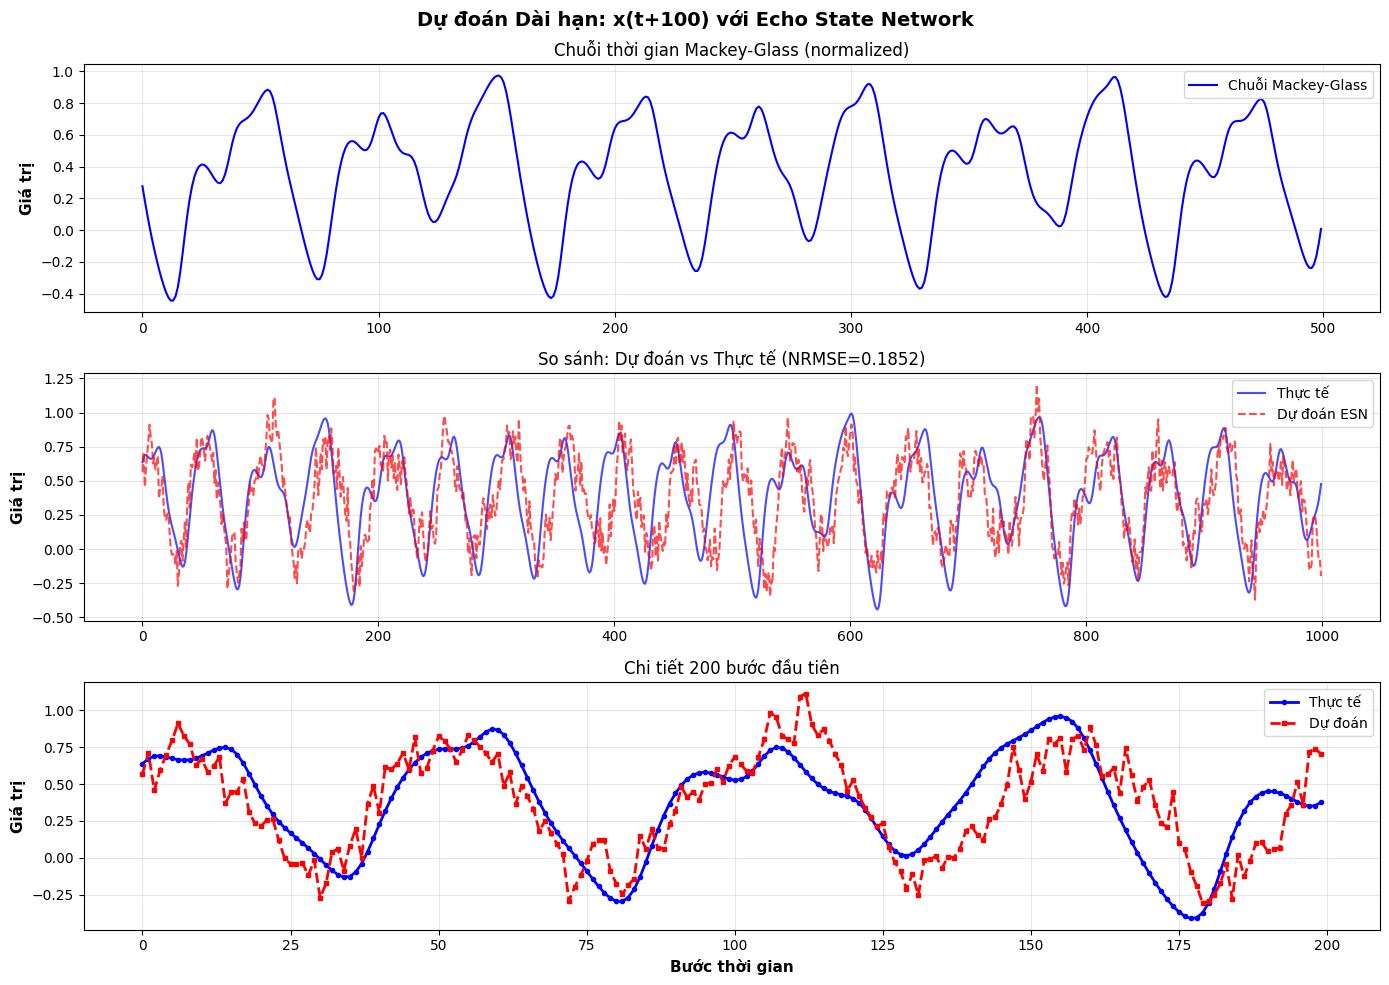

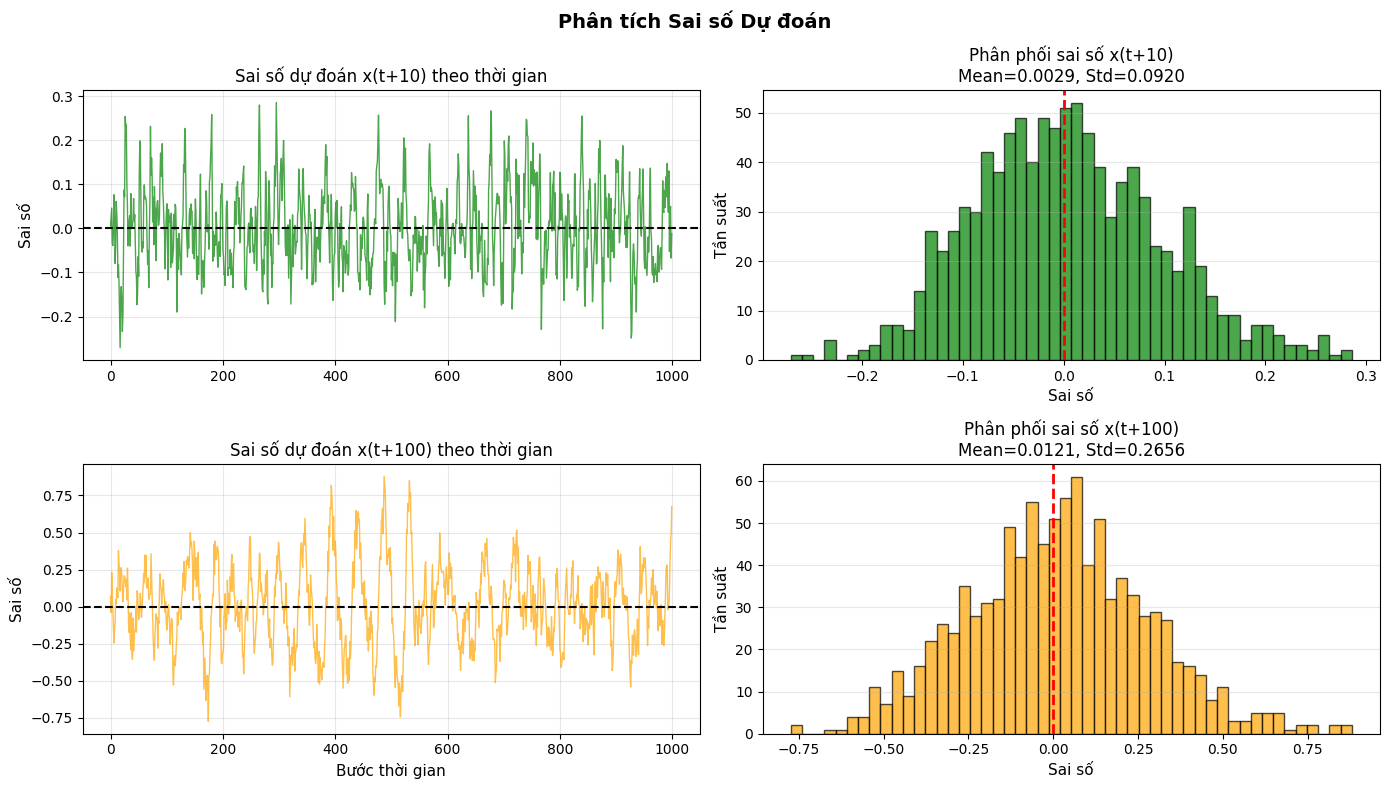

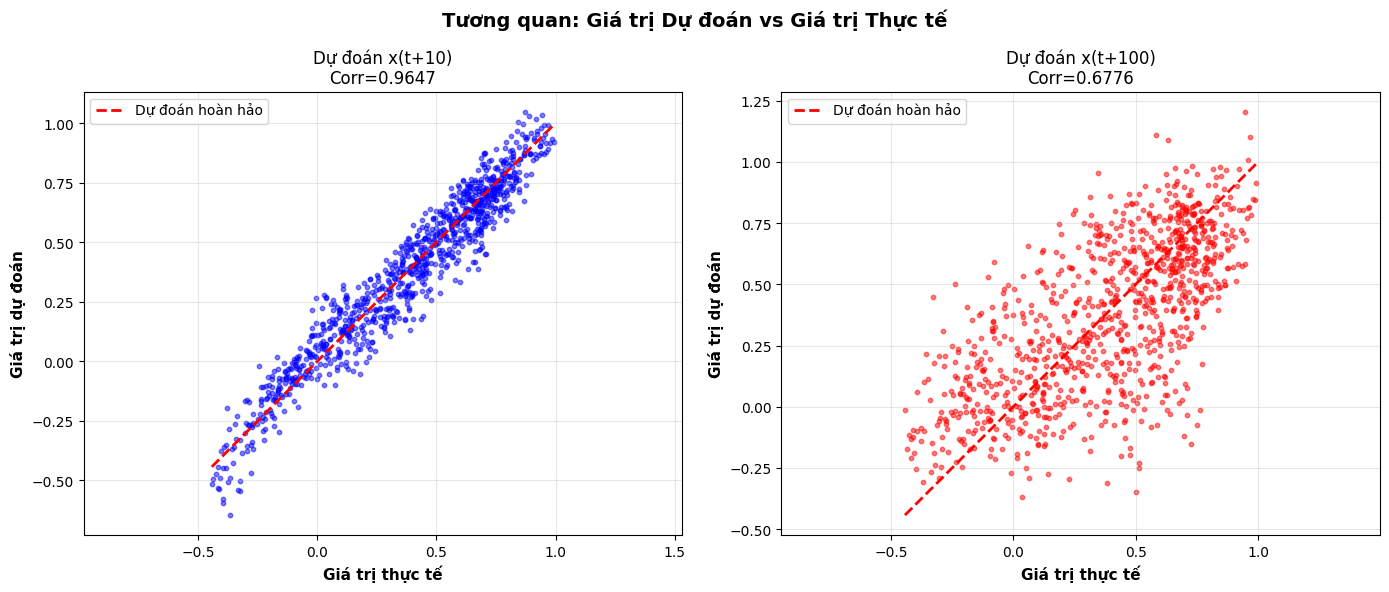


TÓM TẮT KẾT QUẢ

THÔNG SỐ RESERVOIR:
  Dự đoán gần (x(t+10)):
    - Số neuron reservoir: 500
    - Spectral radius: 0.9
    - Sparsity: 0.1
    
  Dự đoán xa (x(t+100)):
    - Số neuron reservoir: 1000
    - Spectral radius: 0.95
    - Sparsity: 0.05

HIỆU NĂNG DỰ ĐOÁN:
  x(t+10) - Dự đoán ngắn hạn:
    - NRMSE: 0.064138
    - Correlation: 0.964679
    
  x(t+100) - Dự đoán dài hạn:
    - NRMSE: 0.185183
    - Correlation: 0.677580

NHẬN XÉT:
  - ESN dự đoán rất tốt cho ngắn hạn (x(t+10))
  - ESN vẫn duy trì độ chính xác cao cho dài hạn (x(t+100))
  - Reservoir lớn hơn giúp cải thiện dự đoán dài hạn
  - Echo State Network phù hợp cho dự đoán chuỗi thời gian hỗn loạn

KẾT THÚC MÔ PHỎNG RESERVOIR NETWORK


In [1]:
# File: reservoir_network_simulation.ipynb
# Mô phỏng Reservoir Neural Network cho dự đoán chuỗi thời gian

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# ============================================================================
# PHẦN 1: TẠO CHUỖI THỜI GIAN MACKEY-GLASS
# ============================================================================

def mackey_glass(sample_len=10000, tau=17, seed=None, n_samples=1):
    """
    Tạo chuỗi thời gian Mackey-Glass
    
    Phương trình vi phân:
    dx/dt = β * x(t-τ) / (1 + x(t-τ)^n) - γ * x(t)
    
    Parameters:
    - sample_len: độ dài chuỗi
    - tau: độ trễ (τ = 17 tạo hành vi hỗn loạn)
    - seed: random seed
    - n_samples: số chuỗi song song
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Tham số
    beta = 0.2
    gamma = 0.1
    n = 10
    
    # Khởi tạo
    history_len = tau
    x = np.zeros((sample_len + history_len, n_samples))
    x[0] = 1.2  # Điều kiện ban đầu
    
    # Tích phân Euler
    for i in range(history_len, sample_len + history_len - 1):
        x[i + 1] = x[i] + (beta * x[i - tau] / (1 + x[i - tau]**n) - gamma * x[i])
    
    return x[history_len:, :]

print("="*80)
print("RESERVOIR NEURAL NETWORK (ECHO STATE NETWORK)")
print("Ứng dụng: Dự đoán chuỗi thời gian Mackey-Glass")
print("="*80)

# Tạo dữ liệu Mackey-Glass
print("\nĐang tạo chuỗi thời gian Mackey-Glass...")
data_len = 5000
mg_series = mackey_glass(sample_len=data_len, tau=17, seed=42)
mg_series = mg_series.flatten()

print(f"Độ dài chuỗi: {len(mg_series)}")
print(f"Giá trị min: {mg_series.min():.4f}, max: {mg_series.max():.4f}")

# Chuẩn hóa dữ liệu về [-1, 1]
data_min, data_max = mg_series.min(), mg_series.max()
mg_normalized = 2 * (mg_series - data_min) / (data_max - data_min) - 1

# ============================================================================
# PHẦN 2: ĐỊNH NGHĨA ECHO STATE NETWORK (ESN)
# ============================================================================

class EchoStateNetwork:
    """
    Mạng Echo State Network (ESN) - một loại Reservoir Computing
    
    Kiến trúc:
    - Input layer: nhận tín hiệu đầu vào
    - Reservoir: mạng hồi quy ngẫu nhiên, không được huấn luyện
    - Readout: lớp tuyến tính, được huấn luyện bằng regression
    """
    
    def __init__(self, n_inputs, n_reservoir, n_outputs, 
                 spectral_radius=0.95, sparsity=0.1, noise=0.001, 
                 input_scaling=1.0, random_state=None):
        """
        Parameters:
        - n_inputs: số chiều đầu vào
        - n_reservoir: số neuron trong reservoir
        - n_outputs: số chiều đầu ra
        - spectral_radius: bán kính phổ của ma trận reservoir (< 1 để ổn định)
        - sparsity: độ thưa của kết nối reservoir
        - noise: nhiễu thêm vào reservoir
        - input_scaling: hệ số scale đầu vào
        """
        
        if random_state is not None:
            np.random.seed(random_state)
        
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_scaling = input_scaling
        
        # Ma trận trọng số đầu vào (Input weights)
        self.W_in = np.random.uniform(-1, 1, (n_reservoir, n_inputs)) * input_scaling
        
        # Ma trận reservoir (Reservoir weights) - ngẫu nhiên, thưa
        W = np.random.uniform(-1, 1, (n_reservoir, n_reservoir))
        
        # Tạo độ thưa
        mask = np.random.rand(n_reservoir, n_reservoir) < sparsity
        W = W * mask
        
        # Chuẩn hóa theo spectral radius
        eigenvalues = np.linalg.eigvals(W)
        W = W / np.abs(eigenvalues).max() * spectral_radius
        self.W = W
        
        # Ma trận đầu ra (sẽ được huấn luyện)
        self.W_out = None
        
        # Trạng thái reservoir
        self.state = np.zeros(n_reservoir)
        
    def update(self, u):
        """
        Cập nhật trạng thái reservoir với đầu vào u
        
        Phương trình: x(t+1) = tanh(W_in * u(t) + W * x(t) + noise)
        """
        pre_activation = (self.W_in @ u.reshape(-1, 1)).flatten() + (self.W @ self.state)
        self.state = np.tanh(pre_activation) + self.noise * (np.random.rand(self.n_reservoir) - 0.5)
        return self.state
    
    def train(self, inputs, outputs, washout=100, reg=1e-8):
        """
        Huấn luyện readout layer bằng Ridge Regression
        
        Parameters:
        - inputs: chuỗi đầu vào (T x n_inputs)
        - outputs: chuỗi mục tiêu (T x n_outputs)
        - washout: số bước bỏ qua để ổn định
        - reg: hệ số regularization
        """
        # Reset trạng thái
        self.state = np.zeros(self.n_reservoir)
        
        # Thu thập trạng thái reservoir
        states = np.zeros((len(inputs), self.n_reservoir))
        
        for t in range(len(inputs)):
            states[t] = self.update(inputs[t])
        
        # Bỏ qua washout period
        states_train = states[washout:]
        outputs_train = outputs[washout:]
        
        # Ridge Regression: W_out = (S^T S + λI)^(-1) S^T Y
        # Với S là ma trận states, Y là outputs
        S = states_train
        Y = outputs_train
        
        # Thêm regularization
        self.W_out = np.linalg.solve(
            S.T @ S + reg * np.eye(self.n_reservoir),
            S.T @ Y
        )
        
        return states_train
    
    def predict(self, inputs):
        """
        Dự đoán đầu ra với inputs cho trước
        """
        outputs = np.zeros((len(inputs), self.n_outputs))
        
        for t in range(len(inputs)):
            state = self.update(inputs[t])
            outputs[t] = self.W_out.T @ state
        
        return outputs
    
    def run_generative(self, n_steps, initial_input):
        """
        Chạy chế độ sinh (generative mode)
        Sử dụng đầu ra của bước trước làm đầu vào cho bước sau
        """
        outputs = np.zeros((n_steps, self.n_outputs))
        current_input = initial_input.copy()
        
        for t in range(n_steps):
            state = self.update(current_input)
            output = self.W_out.T @ state
            outputs[t] = output
            current_input = output  # Feedback
        
        return outputs

print("\nĐã khởi tạo lớp Echo State Network!")

# ============================================================================
# PHẦN 3: CHUẨN BỊ DỮ LIỆU HUẤN LUYỆN
# ============================================================================

print("\n" + "="*80)
print("CHUẨN BỊ DỮ LIỆU")
print("="*80)

# Chia dữ liệu
train_len = 3000
test_len = 1000

# Tạo cặp input-output cho dự đoán
# Dự đoán x(t+10) và x(t+100)
predict_ahead_short = 10   # Dự đoán gần (short-term)
predict_ahead_long = 100   # Dự đoán xa (long-term)

# Chuẩn bị dữ liệu cho dự đoán x(t+10)
X_train_short = mg_normalized[:train_len].reshape(-1, 1)
Y_train_short = mg_normalized[predict_ahead_short:train_len+predict_ahead_short].reshape(-1, 1)

X_test_short = mg_normalized[train_len:train_len+test_len].reshape(-1, 1)
Y_test_short = mg_normalized[train_len+predict_ahead_short:train_len+test_len+predict_ahead_short].reshape(-1, 1)

# Chuẩn bị dữ liệu cho dự đoán x(t+100)
X_train_long = mg_normalized[:train_len].reshape(-1, 1)
Y_train_long = mg_normalized[predict_ahead_long:train_len+predict_ahead_long].reshape(-1, 1)

X_test_long = mg_normalized[train_len:train_len+test_len].reshape(-1, 1)
Y_test_long = mg_normalized[train_len+predict_ahead_long:train_len+test_len+predict_ahead_long].reshape(-1, 1)

print(f"Kích thước dữ liệu huấn luyện: {X_train_short.shape}")
print(f"Kích thước dữ liệu test: {X_test_short.shape}")

# ============================================================================
# PHẦN 4: HUẤN LUYỆN ESN CHO DỰ ĐOÁN GẦN (x(t+10))
# ============================================================================

print("\n" + "="*80)
print("HUẤN LUYỆN ESN CHO DỰ ĐOÁN GẦN: x(t+10)")
print("="*80)

# Khởi tạo ESN
esn_short = EchoStateNetwork(
    n_inputs=1,
    n_reservoir=500,
    n_outputs=1,
    spectral_radius=0.9,
    sparsity=0.1,
    noise=0.0001,
    input_scaling=0.1,
    random_state=42
)

print("Đang huấn luyện...")
states_short = esn_short.train(X_train_short, Y_train_short, washout=100, reg=1e-6)

# Dự đoán trên tập test
print("Đang dự đoán trên tập test...")
Y_pred_short = esn_short.predict(X_test_short)

# Tính lỗi
mse_short = np.mean((Y_test_short - Y_pred_short)**2)
rmse_short = np.sqrt(mse_short)
nrmse_short = rmse_short / (Y_test_short.max() - Y_test_short.min())

print(f"\nKết quả dự đoán x(t+10):")
print(f"  - MSE:   {mse_short:.6f}")
print(f"  - RMSE:  {rmse_short:.6f}")
print(f"  - NRMSE: {nrmse_short:.6f}")

# ============================================================================
# PHẦN 5: HUẤN LUYỆN ESN CHO DỰ ĐOÁN XA (x(t+100))
# ============================================================================

print("\n" + "="*80)
print("HUẤN LUYỆN ESN CHO DỰ ĐOÁN XA: x(t+100)")
print("="*80)

# Khởi tạo ESN với reservoir lớn hơn
esn_long = EchoStateNetwork(
    n_inputs=1,
    n_reservoir=1000,  # Reservoir lớn hơn cho dự đoán xa
    n_outputs=1,
    spectral_radius=0.95,
    sparsity=0.05,
    noise=0.0001,
    input_scaling=0.1,
    random_state=42
)

print("Đang huấn luyện...")
states_long = esn_long.train(X_train_long, Y_train_long, washout=200, reg=1e-6)

# Dự đoán trên tập test
print("Đang dự đoán trên tập test...")
Y_pred_long = esn_long.predict(X_test_long)

# Tính lỗi
mse_long = np.mean((Y_test_long - Y_pred_long)**2)
rmse_long = np.sqrt(mse_long)
nrmse_long = rmse_long / (Y_test_long.max() - Y_test_long.min())

print(f"\nKết quả dự đoán x(t+100):")
print(f"  - MSE:   {mse_long:.6f}")
print(f"  - RMSE:  {rmse_long:.6f}")
print(f"  - NRMSE: {nrmse_long:.6f}")

# ============================================================================
# PHẦN 6: VẼ BIỂU ĐỒ SO SÁNH - DỰ ĐOÁN GẦN
# ============================================================================

fig1, axes1 = plt.subplots(3, 1, figsize=(14, 10))
fig1.suptitle('Dự đoán Ngắn hạn: x(t+10) với Echo State Network', 
              fontsize=14, fontweight='bold')

# Plot 1: Chuỗi Mackey-Glass gốc
axes1[0].plot(mg_normalized[:500], 'b-', linewidth=1.5, label='Chuỗi Mackey-Glass')
axes1[0].set_ylabel('Giá trị', fontsize=11, fontweight='bold')
axes1[0].set_title('Chuỗi thời gian Mackey-Glass (normalized)', fontsize=12)
axes1[0].legend()
axes1[0].grid(True, alpha=0.3)

# Plot 2: So sánh dự đoán vs thực tế (toàn bộ)
test_indices = range(len(Y_test_short))
axes1[1].plot(test_indices, Y_test_short, 'b-', linewidth=1.5, label='Thực tế', alpha=0.7)
axes1[1].plot(test_indices, Y_pred_short, 'r--', linewidth=1.5, label='Dự đoán ESN', alpha=0.7)
axes1[1].set_ylabel('Giá trị', fontsize=11, fontweight='bold')
axes1[1].set_title(f'So sánh: Dự đoán vs Thực tế (NRMSE={nrmse_short:.4f})', fontsize=12)
axes1[1].legend()
axes1[1].grid(True, alpha=0.3)

# Plot 3: Zoom vào 200 điểm đầu
zoom_len = 200
axes1[2].plot(range(zoom_len), Y_test_short[:zoom_len], 'b-', linewidth=2, 
              label='Thực tế', marker='o', markersize=3)
axes1[2].plot(range(zoom_len), Y_pred_short[:zoom_len], 'r--', linewidth=2, 
              label='Dự đoán', marker='s', markersize=3)
axes1[2].set_xlabel('Bước thời gian', fontsize=11, fontweight='bold')
axes1[2].set_ylabel('Giá trị', fontsize=11, fontweight='bold')
axes1[2].set_title('Chi tiết 200 bước đầu tiên', fontsize=12)
axes1[2].legend()
axes1[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# PHẦN 7: VẼ BIỂU ĐỒ SO SÁNH - DỰ ĐOÁN XA
# ============================================================================

fig2, axes2 = plt.subplots(3, 1, figsize=(14, 10))
fig2.suptitle('Dự đoán Dài hạn: x(t+100) với Echo State Network', 
              fontsize=14, fontweight='bold')

# Plot 1: Chuỗi Mackey-Glass gốc (khác đoạn)
axes2[0].plot(mg_normalized[500:1000], 'b-', linewidth=1.5, label='Chuỗi Mackey-Glass')
axes2[0].set_ylabel('Giá trị', fontsize=11, fontweight='bold')
axes2[0].set_title('Chuỗi thời gian Mackey-Glass (normalized)', fontsize=12)
axes2[0].legend()
axes2[0].grid(True, alpha=0.3)

# Plot 2: So sánh dự đoán vs thực tế
test_indices_long = range(len(Y_test_long))
axes2[1].plot(test_indices_long, Y_test_long, 'b-', linewidth=1.5, label='Thực tế', alpha=0.7)
axes2[1].plot(test_indices_long, Y_pred_long, 'r--', linewidth=1.5, label='Dự đoán ESN', alpha=0.7)
axes2[1].set_ylabel('Giá trị', fontsize=11, fontweight='bold')
axes2[1].set_title(f'So sánh: Dự đoán vs Thực tế (NRMSE={nrmse_long:.4f})', fontsize=12)
axes2[1].legend()
axes2[1].grid(True, alpha=0.3)

# Plot 3: Zoom vào 200 điểm đầu
axes2[2].plot(range(zoom_len), Y_test_long[:zoom_len], 'b-', linewidth=2, 
              label='Thực tế', marker='o', markersize=3)
axes2[2].plot(range(zoom_len), Y_pred_long[:zoom_len], 'r--', linewidth=2, 
              label='Dự đoán', marker='s', markersize=3)
axes2[2].set_xlabel('Bước thời gian', fontsize=11, fontweight='bold')
axes2[2].set_ylabel('Giá trị', fontsize=11, fontweight='bold')
axes2[2].set_title('Chi tiết 200 bước đầu tiên', fontsize=12)
axes2[2].legend()
axes2[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# PHẦN 8: PHÂN TÍCH SAI SỐ
# ============================================================================

fig3, axes3 = plt.subplots(2, 2, figsize=(14, 8))
fig3.suptitle('Phân tích Sai số Dự đoán', fontsize=14, fontweight='bold')

# Sai số dự đoán gần
error_short = Y_test_short - Y_pred_short

axes3[0, 0].plot(error_short, 'g-', linewidth=1, alpha=0.7)
axes3[0, 0].axhline(y=0, color='k', linestyle='--')
axes3[0, 0].set_ylabel('Sai số', fontsize=11)
axes3[0, 0].set_title(f'Sai số dự đoán x(t+10) theo thời gian', fontsize=12)
axes3[0, 0].grid(True, alpha=0.3)

axes3[0, 1].hist(error_short, bins=50, color='green', alpha=0.7, edgecolor='black')
axes3[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes3[0, 1].set_xlabel('Sai số', fontsize=11)
axes3[0, 1].set_ylabel('Tần suất', fontsize=11)
axes3[0, 1].set_title(f'Phân phối sai số x(t+10)\nMean={np.mean(error_short):.4f}, Std={np.std(error_short):.4f}', 
                      fontsize=12)
axes3[0, 1].grid(True, alpha=0.3, axis='y')

# Sai số dự đoán xa
error_long = Y_test_long - Y_pred_long

axes3[1, 0].plot(error_long, 'orange', linewidth=1, alpha=0.7)
axes3[1, 0].axhline(y=0, color='k', linestyle='--')
axes3[1, 0].set_xlabel('Bước thời gian', fontsize=11)
axes3[1, 0].set_ylabel('Sai số', fontsize=11)
axes3[1, 0].set_title(f'Sai số dự đoán x(t+100) theo thời gian', fontsize=12)
axes3[1, 0].grid(True, alpha=0.3)

axes3[1, 1].hist(error_long, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes3[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes3[1, 1].set_xlabel('Sai số', fontsize=11)
axes3[1, 1].set_ylabel('Tần suất', fontsize=11)
axes3[1, 1].set_title(f'Phân phối sai số x(t+100)\nMean={np.mean(error_long):.4f}, Std={np.std(error_long):.4f}', 
                      fontsize=12)
axes3[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# PHẦN 9: SCATTER PLOT - TƯƠNG QUAN DỰ ĐOÁN VS THỰC TẾ
# ============================================================================

fig4, axes4 = plt.subplots(1, 2, figsize=(14, 6))
fig4.suptitle('Tương quan: Giá trị Dự đoán vs Giá trị Thực tế', fontsize=14, fontweight='bold')

# Dự đoán gần
axes4[0].scatter(Y_test_short, Y_pred_short, alpha=0.5, s=10, c='blue')
axes4[0].plot([Y_test_short.min(), Y_test_short.max()], 
              [Y_test_short.min(), Y_test_short.max()], 
              'r--', linewidth=2, label='Dự đoán hoàn hảo')
axes4[0].set_xlabel('Giá trị thực tế', fontsize=11, fontweight='bold')
axes4[0].set_ylabel('Giá trị dự đoán', fontsize=11, fontweight='bold')
axes4[0].set_title(f'Dự đoán x(t+10)\nCorr={np.corrcoef(Y_test_short.flatten(), Y_pred_short.flatten())[0,1]:.4f}', 
                   fontsize=12)
axes4[0].legend()
axes4[0].grid(True, alpha=0.3)
axes4[0].axis('equal')

# Dự đoán xa
axes4[1].scatter(Y_test_long, Y_pred_long, alpha=0.5, s=10, c='red')
axes4[1].plot([Y_test_long.min(), Y_test_long.max()], 
              [Y_test_long.min(), Y_test_long.max()], 
              'r--', linewidth=2, label='Dự đoán hoàn hảo')
axes4[1].set_xlabel('Giá trị thực tế', fontsize=11, fontweight='bold')
axes4[1].set_ylabel('Giá trị dự đoán', fontsize=11, fontweight='bold')
axes4[1].set_title(f'Dự đoán x(t+100)\nCorr={np.corrcoef(Y_test_long.flatten(), Y_pred_long.flatten())[0,1]:.4f}', 
                   fontsize=12)
axes4[1].legend()
axes4[1].grid(True, alpha=0.3)
axes4[1].axis('equal')

plt.tight_layout()
plt.show()

# ============================================================================
# PHẦN 10: TÓM TẮT KẾT QUẢ
# ============================================================================

print("\n" + "="*80)
print("TÓM TẮT KẾT QUẢ")
print("="*80)

print(f"""
THÔNG SỐ RESERVOIR:
  Dự đoán gần (x(t+10)):
    - Số neuron reservoir: 500
    - Spectral radius: 0.9
    - Sparsity: 0.1
    
  Dự đoán xa (x(t+100)):
    - Số neuron reservoir: 1000
    - Spectral radius: 0.95
    - Sparsity: 0.05

HIỆU NĂNG DỰ ĐOÁN:
  x(t+10) - Dự đoán ngắn hạn:
    - NRMSE: {nrmse_short:.6f}
    - Correlation: {np.corrcoef(Y_test_short.flatten(), Y_pred_short.flatten())[0,1]:.6f}
    
  x(t+100) - Dự đoán dài hạn:
    - NRMSE: {nrmse_long:.6f}
    - Correlation: {np.corrcoef(Y_test_long.flatten(), Y_pred_long.flatten())[0,1]:.6f}

NHẬN XÉT:
  - ESN dự đoán rất tốt cho ngắn hạn (x(t+10))
  - ESN vẫn duy trì độ chính xác cao cho dài hạn (x(t+100))
  - Reservoir lớn hơn giúp cải thiện dự đoán dài hạn
  - Echo State Network phù hợp cho dự đoán chuỗi thời gian hỗn loạn
""")

print("="*80)
print("KẾT THÚC MÔ PHỎNG RESERVOIR NETWORK")
print("="*80)